In [1]:
#Bismillahir Rahmanir Raheem

# Kaggle Notebook Link -> [Bengali Tafsir ibn kathir Reader](https://www.kaggle.com/code/mobassir/bengali-tafsir-ibn-kathir-reader)

In this Notebook we will try to convert bengali **Tafsir Ibn Kathir (তাফসীর ইবনে কাসীর ) book from pdf to text format, this book is one of the Most Comprehensive and Complete Explanation of The Noble Quran. Translated in to the Bangla language for the First time in the History of Islam!** after conversion,we'll save the converted file in pkl format for later use of nlp, data analysis and text to speech(TTS) related tasks

for multilingual pdf to text conversion we will use this awesome library **[multilingual-pdf2text](https://github.com/shahrukhx01/multilingual-pdf2text)**

# changeLog :
v2 -> part1 and part7 ✔️ 

v3 -> part2 and part3 (error : Your notebook tried to allocate more memory than is available.0)

v4 -> part2 only (simple bug)

v5 -> part2 only and fixing bug ✔️ 

v6 -> part3 (failed,because part3 is bigger than any other parts and for part3 even ram space of kaggle is small,will have to try it in another workspace)

v7 -> part4 ✔️ 

v8 -> part5 ✔️ 

v9 -> part6 ✔️

v10 -> part8 ✔️

v11 -> part9 ✔️

v12 -> part10 ✔️

v13 -> part11

v14 -> made .pkl of part3 using local pc where i have access to 32gb ram and uploaded that pkl file in this [folder](https://www.kaggle.com/mobassir/tafsir-ibn-kathir-by-islamic-foundation?select=tafsiribnkathir_pkl) , added code for bangla wordcloud of full tafsir book and also added gtts trial in one chunk of this book

v15 -> converting each pdf page into seperate image using pymupdf for later OCR works(because pytesseract is performing horribly here for bangla)

v16 -> there are many images in each directory after converting pdf to images,we will convert each directory into seperate zip file

v17 -> fixing bug of v16

v18 -> uploaded all the images(converted from pdf) in [this dataset](https://www.kaggle.com/mobassir/tafsir-ibn-kathir-bangla) and in [this dataset](https://www.kaggle.com/mobassir/tafsir-ibn-kathir-by-islamic-foundation) for later OCR related works,in v18 we will try to convert english tafsir ibn kathir pdf parts into images

v19 -> easyocr trial

v20 -> easyocr trial on english version of tafsir ibn kathir

v21 -> silero bangla reader

In [2]:
%%capture 

!pip install  gTTS
#!pip install PyPDF2
!pip install playsound
!pip install multilingual-pdf2text==1.1.0
!apt install -y tesseract-ocr
!apt install -y libtesseract-dev
!apt-get install -y poppler-utils 
!apt-get install tesseract-ocr-ara
!apt-get install tesseract-ocr-ben
!pip install wordcloud
!pip install bnlp_toolkit
!pip install googletrans==4.0.0-rc1
!pip install pymupdf
!pip install easyocr
!pip install aksharamukha
!pip install -q torchaudio omegaconf
!!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
    

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from multilingual_pdf2text.pdf2text import PDF2Text
from multilingual_pdf2text.models.document_model.document import Document
import logging
import time
import pickle
from pathlib import Path
import csv
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

logging.basicConfig(level=logging.INFO)


import cv2
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bnlp.corpus import stopwords, punctuations

from googletrans import Translator
from gtts import gTTS
import IPython.display as ipd
import fitz
import shutil
import zipfile
from tqdm import tqdm
from PIL import Image

import torch
import easyocr
import torchaudio
from IPython.display import Audio, display
from aksharamukha import transliterate
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print(torch.__version__)
print(cv2.__version__)

1.11.0+cu113
4.5.4


# Control Panel


In [5]:
selected = ['tafsiribnkathir_part11']#pdf books to convert into text
pdf_to_txt = False #if True,convert pdf2text
use_pkl = True #if True,explore saved pkl files
use_dir = 'tafsir-ibn-kathir-by-islamic-foundation'
use_dir1 = 'tafsir-ibn-kathir-bangla'
use_eng = '/tafsir-ibn-kathir-in-english/images'
pdf_to_imgs = False
easy_ocr_demo = True  #if true, only process surah fatiha,otherwise process all 114 surah's
directory = []

careful,
if you work on colab,colab notebooks can crash because of low ram space there compared to what we have here in kaggle,you need sufficient ram to covert these large pdf files into text,to avoid such issue,i recommend to convert not more than 1 pdf at a time here in kaggle and avoid using colab workspace for this task,for better understanding this problem please [check this issue](https://github.com/shahrukhx01/multilingual-pdf2text/issues/4)

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    if(use_eng not in dirname):
        continue
    for filename in filenames:
        directory.append(os.path.join(dirname, filename))

In [7]:
len(directory)

6845

# Multilingual pdf2text

In [8]:
def pdf_to_pkl(dir):
    ck = 0
    for i in range(len(selected)):
        if(selected[i] in dir):
            ck = 1
            break
        else:
            ck = 0
    if(not ck):
        return
    print('converting -> ',dir,"of islamic foundation into text")
    pdf_document = Document(
    document_path=dir,
    language='ben+ara'
    )
    pdf2text = PDF2Text(document=pdf_document)
    content = pdf2text.extract()
    #print(content[5])
    source = Path(dir).stem
    with open(f'{source}.pkl', 'wb') as fp:
        pickle.dump(content, fp)
    

In [9]:
%%time
if(pdf_to_txt):
    for i in range(len(directory)):
        pdf_to_pkl(directory[i])



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [10]:
if(use_pkl):
    print("\nreading a .pkl file : \n")

    with open(f'../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/{selected[0]}.pkl', 'rb') as f:
        data = pickle.load(f)

    print(data[24])


reading a .pkl file : 

{'page_number': 25, 'text': "(001769175\n\n২৬ তাফসীরে ইব্\u200cন কাছীর\n\nউহাদিগকে অন্য শাস্তি দেওয়া হইত। যেমন হত্যা করা হইত, বন্দী করা হইত ইত্যাদি।\nআল্লাহ্\u200c তা'আলার ফয়সালা এই ছিল যে, তিনি আখিরাতে জাহান্নামের শাস্তির সাথে\nসাথে তিনি তাহাদিগকে দুনিয়াতেও চরম শিক্ষণীয় শাস্তি প্রদান করিবেন।\n\nইব্\u200cন আবু হাতিম (র) .... উরওয়া ইবৃন যুবায়র (রা) হইতে বর্ণনা করেন যে,\nউরওয়া (রা) বলেন $ বদর যুদ্ধের ছয় মাস পর বনূ নাধীরের ইয়াহুদীদের সহিত\nমুসলমানদের যুদ্ধ হয়। রাসূলুল্লাহ (সা) মদীনার এক প্রান্তে বসবাসকারী এই\nসম্প্রদায়টিকে প্রথমে অবরোধ করিয়া রাখেন এবং পরে নির্বাসনে বাধ্য করেন। অন্তর ছাড়া\nঅন্যান্য আসবাবপত্র লইয়া যাওয়ার অনুমতি ছিল। উরওয়া (রা) বলেন ঃ তাওরাতের\nবিধান অনুযায়ীই তাহাদিগকে নির্বাসন দেওয়া হয়। ইতিপূর্বে ইহাদিগের সম্প্রদায়ের কেহ\nকখনো নির্বাসিত হইয়াছিল না। ইহাদিগের সম্পর্কেই আল্লাহ তা'আলা 11 ০...\n১80811১৯515 আয়াত অবতীর্ণ হয়।\n\nইকরিমা (রে) বলেন ঃ আলোচ্য আয়াতে 2. অর্থ হত্যা বা নিপাত । কাতাদা রে)\nবলেন 5 2১ অর্থ এক দেশ ছাড়িয়া আরেক দ

In [11]:
if(use_pkl):
    print(data[20:30])

[{'page_number': 21, 'text': "(001769175\n\n২২ তাফসীরে ইব্\u200cন কাছীর\n\nআঘাতে তোমাদিগকে নিপাত করিয়া দিব এবং তোমাদিগের স্ত্রী-কন্যাদিগকে\nআমাদিগের দাসী বানাইয়া লইব। এই পত্র পাইয়া আব্দুল্লাহ্\u200c ইব্\u200cন উবাই এবং তাহার\nসাঙ্গপাঙ্গরা পরামর্শ করিয়া মুহাম্মদ (সা)-এর সহিত লড়াই করিবার গোপন সিদ্ধান্ত\nগ্রহণ করে। এই সংবাদ শুনিতে পাইয়া রাসূলুল্লাহ্\u200c (সা) নিজে তাহাদিগের সহিত সাক্ষাৎ\nকরিয়া তাহাদিগের সহিত এই বিষয়ে আলাপ করেন। ফলে তাহারা পূর্বের সিদ্ধান্ত\nপরিবর্তন করিয়া ফেলে।\n\nঅতঃপর কুরাইশরা এই সিদ্ধান্ত পরিবর্তনের সংবাদ পাইয়া বদর যুদ্ধের পর\nইয়াহুদীদের নিকট পুনরায় পত্র লিখে যে, তোমরা মজবুত দুর্গের অধিকারী ও শক্তিশালী\nসম্প্রদায় । মুহাম্মদের সহিত যুদ্ধ না করিলে আমরা তোমাদিগকে রেহাই দিব না।\nতোমরা আক্রমণ কর, আমরা তোমাদিগের যথাসাধ্য সহযোগিতা করিব।\n\nএইবার বনূ নাধীর বিশ্বাসঘাতকতা করিবার চূড়ান্ত সিদ্ধান্ত গ্রহণ করে এবং\nরাসূলুল্লাহ্\u200c (সা)-এর নিকট এই প্রস্তাব পাঠায় যে, আপনি আপনার সাহাবীদের মধ্য\nহইতে ত্রিশজন লোক প্রেরণ করুন, আমাদের মধ্য হইতেও ব্রিশজন বিজ্ঞ লোক\nআসিতেছ

In [12]:
if(use_pkl):
    print(data[25]['text'])

53053

সূরা হাশ্র ২৭

অর্থাৎ তোমরা যে খর্জুর বৃক্ষগুলি কর্তন করিয়াছ এবং যেগুলি কাণ্ডের উপর স্থির
রাখিয়া দিয়াছ; তাহাতো আল্লাহরই অনুমতিতে; ইহা এইজন্য যে, তিনি
পাপাচারীদেরকে লাঞ্িত করিবেন ।

?5-4 উন্নতমানের এক ধরনের খেজুর বৃক্ষকে বলা হয়। আবু উবায়দা (রা) বলেনঃ
আজওয়া ও বারনী খর্জুর ব্যতীত অন্যান্য খর্ব বৃক্ষকে %-) বলা হয়। বহুসংখ্যক
মুফাস্সিরের মত হইল, 'আজওয়া ছাড়া সকল বর্ণের খেজুর বৃক্ষকেই % €: বলা হয়।
‏جد‎ জারীর রে) বলেন ঃ যে কোন খর্জরবৃক্ষকেই% 1 বলা হয় এবং ইহা মুজাহিদ
(র)-এরও মত।

বনূ নাধীরের সম্প্রদায়কে অবরোধ করিবার পর রাসূলুল্লাহ্‌ (সা):তাহাদের ভীতি ও
ঘৃণা প্রদর্শন ও হুমকিরূপে তাহাদিগের খর্জুর বৃক্ষগুলি কাটিয়া ফেলার নির্দেশ দেন।

যায়েদ ইব্‌ন রূমান, কাতাদা ও মুকাতিল ইব্‌ন হায়য়ান (র) বলেন ৪ বনূ নাধীরের
এই ঘটনার পর বনু কুরায়ঘা এই বলিয়া অভিযোগ তোলে যে, কি।ব্যাপার ? আপনি
দেশে শান্তি প্রতিষ্ঠার কথা বলিতেছেন আর এইসব ধ্বংস চালাইতেছেন ? এই .
অভিযোগের উত্তরে আল্লাহ্‌ তা“আলা এই আয়াতটি নাধিল করেন । অর্থাৎ খর্জুর বৃক্ষ
কর্তন করা বা কর্তন না করিয়া নিরাপদে রাখিয়া দেওয়া এই সবই আল্ল

# Merging All .pkl files for making wordcloud of full book

In [13]:
all_pickles = [
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part1.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part2.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part3.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part4.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part5.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part6.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part7.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part8.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part9.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part10.pkl',
    '../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_pkl/tafsiribnkathir_part11.pkl',
]
merger = []
for i in range(len(all_pickles)):
    with open(all_pickles[i], 'rb') as f:
            data = pickle.load(f)
    merger.append(data)
              


In [14]:
len(merger)

11

In [15]:
merged_data = [x for xs in merger for x in xs]
len(merged_data)

7680

In [16]:
len(merger[1])

795

In [17]:
full_tafsir = ' '

for i in range(len(merged_data)):
    full_tafsir += merged_data[i]['text']+' '

In [18]:
len(merged_data)

7680

# Bangla Tafsir word cloud

In [19]:

#taken from : https://medium.com/geekculture/a-simple-guide-to-creating-a-bengali-word-cloud-of-any-shape-d118ec523e30


def clean(text):
    text = re.sub('[%s]' % re.escape(punctuations), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\xa0', '', text)
    
    text = re.sub('\u200f', '', text)
    text = re.sub('\u200e', '', text)
    text = re.sub('\u200c', '', text)
    text = re.sub('\x0c', '', text)
    
    return text

cleaned_text = clean(full_tafsir)


In [20]:
import requests
image_url = 'https://st.depositphotos.com/1031166/3076/i/950/depositphotos_30768325-stock-photo-beautiful-white-mosque.jpg'
img_data = requests.get(image_url).content
with open('awesome_mosque.jpg', 'wb') as handler:
    handler.write(img_data)

In [21]:
def get_mask(img_path):
    img = cv2.imread(img_path, -1)
    if img.shape[2] == 3:
        return img
    return cv2.bitwise_not(img[:, :, 3])

mask = get_mask("./awesome_mosque.jpg")

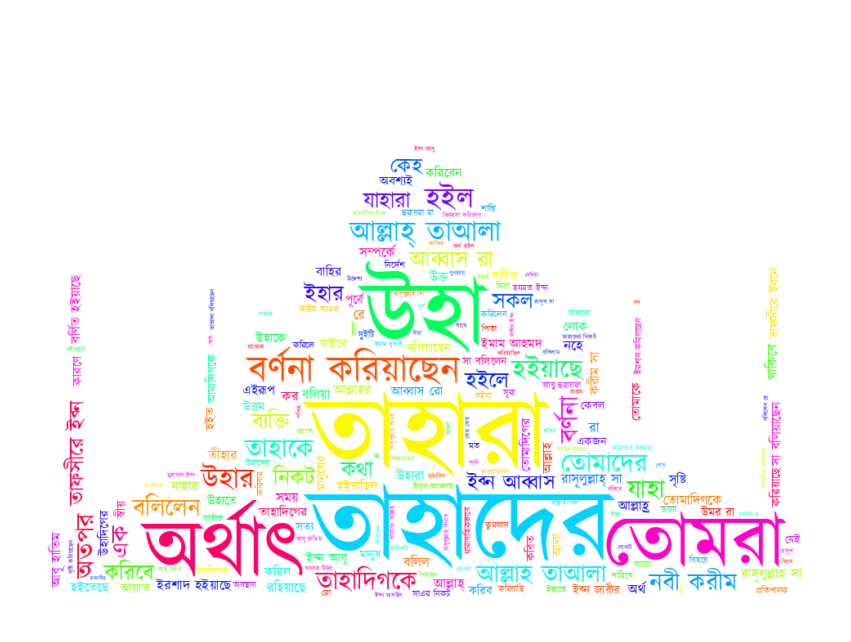

In [22]:
regex = r"[\u0980-\u09FF]+"
wc = WordCloud(width=800, height=800,mode="RGBA",background_color=None,colormap="hsv",mask=mask,stopwords = stopwords,
font_path="../input/kalpurush-fonts/kalpurush-2.ttf",regexp=regex).generate(cleaned_text)
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
result = wc.to_file("Bengali_Tafsir_word_cloud.png")

# Multilingual Tafsir Reader

Note : if you have any other recommendation for multilingual text to speech pipeline other than gtts and googletrans for handling multi language text in single line input(typically mixture of bangla,english and arabic) then please let us know in the comment below,it will be highly appreciated,thanks

In [23]:

#from : https://stackoverflow.com/questions/70852444/how-to-use-muti-language-in-gtts-for-single-input-line

cleaned_chunk = clean(data[4]['text'])
input_text = " ٱلْحَمْدُ لِلَّٰه "+cleaned_chunk[2:]
#input_text = cleaned_chunk[2:]
words = input_text.split(" ")
translator = Translator()
language, sentence = None, ""

lang_code_table = {"sd": "ar"}

with open('output.mp3', 'wb') as ff:
    for word in words:
        # Detect language of current word
        try:
            word_language = translator.detect(word).lang
        except Exception:
            print('failed to detect language of this word -> ',word)
            continue

        if word_language == language:
            # Same language, append word to the sentence
            sentence += " " + word
        else:
            if language is None:
                # No language set yet, initialize and continue
                language, sentence = word_language, word
                continue

            # We have whole previous sentence, translate it into speech and append to mp3 file
            gTTS(text=sentence, lang=lang_code_table.get(language, language), slow=False).write_to_fp(ff)

            # Continue with other language
            language, sentence = word_language, word

    if language and sentence:
        # Append last detected sentence
        gTTS(text=sentence, lang=lang_code_table.get(language, language), slow=False).write_to_fp(ff)

failed to detect language of this word ->  
failed to detect language of this word ->  
failed to detect language of this word ->  


In [24]:
#play output.mp3 file

fname = './' + 'output.mp3'   
print(input_text)
ipd.Audio(fname)

 ٱلْحَمْدُ لِلَّٰه মুসলিম বিশ্বে প্রসিদ্ধি অর্জন করেছে এই গ্রন্থ সম্পর্কে আল্লামা সুযূতী র বলেছেন  “এধরনের তাফসীর গ্রন্থ এর আগে কেউ রচনা করেন নি” আল্লামা শাওকানী রে এই গ্রন্থটিকে“সবেত্তিম তাফসীর গ্রন্থগুলোর অন্যতম” বলে মন্তব্য করেছেন আল্লাহ তাআলার অশেষ মেহেরবানীতে আমরা এই তাফসীর গ্রন্থের বাংলা অনুবাদেরকাজ  খণ্ডে সমাপ্ত করে বাংলাভাষী পাঠকদের সামনে উপস্থাপন করতে পেরেছি অনুবাদেরগুরু দায়িত্ব পালন করেছেন প্রখ্যাত আলিম শিক্ষাবিদ অধ্যাপক মাওলানা আখতার ফারুক গ্রন্থটির একাদশ খণ্ডের সবগুলো কপি ফুরিয়ে যাওয়ায় এবারএর তৃতীয় সংস্করণ প্রকাশ করাহলোএই অমূল্য গ্রন্থখানির অনুবাদ সম্পাদনা এবং প্রকাশনার বিভিন্ন পর্যায়ে জড়িত থেকে যারাগুরুত্পূর্ণ অবদান রেখেছেন তাদের সকলকে আন্তরিক মুবারকবাদ জানাই মহান আল্লাহ আমাদের সকলকে এই তাফসীর গ্রন্থের মাধ্যমে ভালোভাবে কুরআন বোঝাএবং সেই অনুযায়ী আমল করার তাওফিক দিন আমীন সামীম মোহাম্মদ আফজালমহাপরিচালকইসলামিক ফাউন্ডেশন


In [25]:
#taken from : https://www.kaggle.com/xhlulu/recursion-2019-load-resize-and-save-images

def zip_and_remove(path):
    ziph = zipfile.ZipFile(f'{path}.zip', 'w', zipfile.ZIP_DEFLATED)
    for root, dirs, files in os.walk(path):
        for file in tqdm(files):
            file_path = os.path.join(root, file)
            ziph.write(file_path)
            #os.remove(file_path)
    ziph.close()
    shutil.rmtree(path)

In [26]:


def pdf2imgs(pdffile):
    try:
        doc = fitz.open(pdffile)
    except:
        print("An exception occurred")
        return
    part = Path(pdffile).stem
    part = part.replace(" ", "_")
    print("working on this pdf -> ",part)
    if(os.path.exists(f'./{part}')):
        print("deleting old data...")
        shutil.rmtree(f'./{part}')
    os.mkdir(f'./{part}')
    
    for page_number in range(len(doc)):
        page = doc.loadPage(page_number)  # number of page
        zoom = 2    # zoom factor https://github.com/pymupdf/PyMuPDF/issues/181
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix = mat)
        output = f"./{part}/{part}_page_{page_number}.png"
        pix.save(output)
    zip_and_remove(f'./{part}')


In [27]:
%%time

if(pdf_to_imgs):
    for i in range(len(directory)):
        if('tafsiribnkathir_pkl' in directory[i]):
            continue
        pdf2imgs(directory[i])



CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


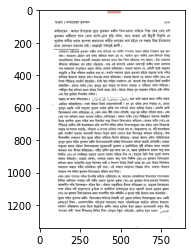

In [28]:

plt.imshow(cv2.imread('../input/tafsir-ibn-kathir-by-islamic-foundation/tafsiribnkathir_part1/tafsiribnkathir_part1/tafsiribnkathir_part1_page_105.png'))

In [29]:
!ls

Bengali_Tafsir_word_cloud.png  awesome_mosque.jpg
__notebook__.ipynb	       output.mp3


# EasyOCR demo

In [30]:
#Image to text using easyocr,Output will be in list format, each item represents bounding box, text and confident level, respectively.

reader = easyocr.Reader(['en','ar'], gpu=True)
img_text = reader.readtext('../input/tafsir-ibn-kathir-in-english/images/001_Fatihah/001_Fatihah/001_Fatihah_page_0.png')
final_text = ""

for _, text, __ in img_text: # _ = bounding box, text = text and __ = confident level
    final_text += " "
    final_text += text
final_text

" Tafsir Ibn Kسthir دلك الكثاب لاريب فيه هدًى للمثقين ٨٥١ ٨٨٨٨٨٥٢ ١٨ ،٥١٨٥٥١١٨٨٨٨٥٥١٨٨,١٨٨٨٢٨١٨؟٨١٨٨ A Fatihah Revealed in Makkah The Meaning of Al Fatehah and its Various Names This Surah is called Al Fatihah  that is, the Opener of the Book  the Surah with which prayers are begun. It is also called, Umm Al- Kitab (the Mother of the Book ) according to the majority of the scholars. In a٨ authentic   Hadith recorded by At- Tirmidhi who graded it Sahih, Abu Hurayrah said that the Messenger of Allah said الحمد لله رب العالمين أمً القرآن وأمً الكتاب والقرآن العظيم Al-Hamdu Iillahi Rabbil- Alamin is the Mother of the Qur'a the Mother of the Book, and the seven repeated Ayat of the Glorious Quran It is also called Al Hamd and As-Salah  because the Prophet that his Lord said نصفين قسمت الصلاةً بيني وبين المثاني والسبع 'an, said عبدي"

In [31]:
# ref : https://www.kaggle.com/badhansen/text-extraction-from-images-easyocr-pytesseract/notebook

# Image directory and list of files

def get_files(directory):
    path, directory, files = next(os.walk(directory))
    return files

def get_easyocr_output(directory):
    files_list = get_files(directory)
    # Doing OCR using GPU
    # save the images text to dict
    images_text = {}
    for files in files_list:
        img_text = reader.readtext(directory + '/' +  files)
        final_text = ""
        for _, text, __ in img_text:
            final_text += " "
            final_text += text
        images_text[files] = final_text
        
    # For sorting the image file name
    keys = list(images_text.keys())
    
    splitted = keys[0].split('_page_')
    split_len = len('_page_')
    new_keys = [int(k[len(splitted[0])+split_len:-4]) for k in keys]
    file_name = keys[0][:len(splitted[0])+split_len]
    new_keys.sort()
    name = keys[0][:len(splitted[0])]

    # Saving the Text file with image name ascending order
    with open(f'{name}.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Text"])
        for n in new_keys:
            writer.writerow([f'{file_name}'+str(n) + '.png', images_text[f'{file_name}'+str(n) + '.png']])



In [32]:
%%time
dirs = sorted(os.listdir('../input/tafsir-ibn-kathir-in-english/images'))
print(len(dirs))
for i in range(len(dirs)):
    if(easy_ocr_demo):
        if(i>0):
            break
    directory = f'../input/tafsir-ibn-kathir-in-english/images/{dirs[i]}/{dirs[i]}'
    get_easyocr_output(directory)
    print(f"Finished processing surah -> {dirs[i]}")

114
Finished processing surah -> 001_Fatihah
CPU times: user 2min 27s, sys: 2.23 s, total: 2min 29s
Wall time: 2min 30s


In [33]:
Fatihah_001 = pd.read_csv('./001_Fatihah.csv')
Fatihah_001.head(5)

,Filename,Text
0,001_Fatihah_page_0.png,Tafsir Ibn Kسthir دلك الكثاب لاريب فيه هدًى ل...
1,001_Fatihah_page_1.png,فإذا قال العبد : الحمددلله رب العالمين قال ا...
2,001_Fatihah_page_2.png,the successive generations the Bismillah is ...
3,001_Fatihah_page_3.png,It is Umm Al-Qur'an the seven repeated (vers...
4,001_Fatihah_page_4.png,It is the seven repeated (verses ) and the Gl...


# silero-tts demo for bangla

In [34]:
cleaned_text[1500:3000]

'ীকে থামিতে বলাকতদিনে কুরআন খতম বিধেয়তিলাওয়াতকালে ক্রন্দনকুরআনের লোক দেখানো প্রীতির নিন্দাকুরআনে তিলাওয়াতে মনোযোগের গুরুত্কতিপয় জরুরী হাদীস কুরআন মজীদ স্মরণ রাখিবার দোয়াদ্বিতীয় অধ্যায়সুরা ফাতিহাউপক্রমণিকাপ্রয়োজনীয় কথা সুরা আলফাতিহাসূরা ফাতিহার ফযীলত সম্পর্কিত হাদীসসমূহউক্ত হাদীস সম্পর্কে জরুরী আলোচনা আউযুবিল্লাহর ব্যাখ্যা ও বিধানইস্তিআযার অর্থ নিরপণ“আর রাজীম শব্দের বিশ্লেষণবিসমিল্রাহর বিশ্লেষণবিসমিল্লাহ্র ফযীলত“ইসমএর তাৎপর্য আল্লাহ্ শব্দের গঠনপ্রকৃতি ও তাৎপর্যআলহামদুর তাৎপর্য মালিকি ইয়াওমিদ্দীনইয়্যাকা নাবুদু ওয়া ইয়যাকা নাস্তাঈনইহদিনাস সিরাতাল মুস্তাকী كأمعامه াচসিরাতাল্লাধীনা আন আমতা আলায়হিম গায়রিল মাগদুবি আলায়হিম ওলাদ দাল্লীন াল্লীন ও জাল্লীন সমস্যা ا াতিহার বিষয়বস্তু  ীন প্রসঙ্গ ৃতীয় অধ্যায়আলিফলাম পারাসুরা বাকারার ফযীলত সম্পর্কিত বর্ণনাসমূহ ূরা আলে ইমরানসহ সূরা বাকারার ফযীলত সম্পর্কিত বর্ণনা ীর্ঘ সাত সূরার ফযীলত সম্পর্কিত বর্ণনাসমূহ ুরা বাকারা সম্পর্কিত জরুরী আলোচনা ূরা বাকারার তাফসীর প্রথম আয়াত হুরুফে মুকাত্তাআত ্বিতীয় আয়াত মুস্তাকীদের বৈশিষ্ট্য  ৃতীয় আয়াত মৃ

we can see from above output that easyocr is giving very noisy text which we can't use for our book  reader,that's why in this repository we are trying to make [Multilingual-Reader](https://github.com/mobassir94/Multilingual-Reader) .
for now,let's use hardcoded strings for silero bangla tts demo to see how it speaks,later we will use something better than easyocr for ocr task,inshaa allah.

In [35]:
fatihah = ["১. বিসমিল্লাহির রাহমা-নির রাহি-ম।",
           "২. আলহামদু লিল্লাহি রাব্বিল আ’-লামি-ন।",
           "৩. আররাহমা-নির রাহি-ম।",
           "৪. মা-লিকি ইয়াওমিদ্দি-ন।",
           "৫. ইয়্যা-কা না’বুদু ওয়া ইয়্যা-কা নাসতাই’-ন।",
           "৬. ইহদিনাস সিরাতা’ল মুসতাকি’-ম।",
           "৭. সিরাতা’ল্লা যি-না আনআ’মতা আ’লাইহিম, গা’ইরিল মাগ’দু’বি আ’লাইহিম ওয়ালাদ্দ—ল্লি-ন।আমিন।"]
len(fatihah)

7

In [36]:
sample_rate = 48000
# Loading model
model, example_text = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                     model='silero_tts',
                                     language='indic',
                                     speaker='v3_indic')
for i in range(len(fatihah)):
    orig_text = fatihah[i]
    print("\n\norig_text -> ",orig_text)
    roman_text = transliterate.process('Bengali', 'ISO', orig_text)
    print("\n\nroman_text -> ",roman_text)
    if (i % 2) == 1:
        audio = model.apply_tts(roman_text,
                            speaker='bengali_male')
    else:
        audio = model.apply_tts(roman_text,
                            speaker='bengali_female')
    
    torchaudio.save(f'ayat_{i+1}.wav', audio.unsqueeze(0), sample_rate)
    display(Audio(audio, rate=sample_rate))

Downloading: "https://github.com/snakers4/silero-models/archive/master.zip" to /root/.cache/torch/hub/master.zip


  0%|          | 0.00/54.5M [00:00<?, ?B/s]



orig_text ->  ১. বিসমিল্লাহির রাহমা-নির রাহি-ম।


roman_text ->  1. bisamillāhira rāhamā-nira rāhi-ma.




orig_text ->  ২. আলহামদু লিল্লাহি রাব্বিল আ’-লামি-ন।


roman_text ->  2. ālahāmadu lillāhi rābbila ā’-lāmi-na.




orig_text ->  ৩. আররাহমা-নির রাহি-ম।


roman_text ->  3. ārarāhamā-nira rāhi-ma.




orig_text ->  ৪. মা-লিকি ইয়াওমিদ্দি-ন।


roman_text ->  4. mā-liki iẏāōmiddi-na.




orig_text ->  ৫. ইয়্যা-কা না’বুদু ওয়া ইয়্যা-কা নাসতাই’-ন।


roman_text ->  5. iẏyā-kā nā’budu ōẏā iẏyā-kā nāsatāi’-na.




orig_text ->  ৬. ইহদিনাস সিরাতা’ল মুসতাকি’-ম।


roman_text ->  6. ihadināsa sirātā’la musatāki’-ma.




orig_text ->  ৭. সিরাতা’ল্লা যি-না আনআ’মতা আ’লাইহিম, গা’ইরিল মাগ’দু’বি আ’লাইহিম ওয়ালাদ্দ—ল্লি-ন।আমিন।


roman_text ->  7. sirātā’llā yi-nā ānaā’matā ā’lāihima, gā’irila māga’du’bi ā’lāihima ōẏālādda—lli-na.āmina.


![](https://www.pngitem.com/pimgs/m/536-5367552_work-in-progress-banner-hd-png-download.png)